In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<center>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>''')


Overview
===
In this script I'll be exploring a Pokemon dataset compiled from Serebii.net with information like base stat totals (the sum of all individual stats for a Pokemon), Pokemon names, height/weight, type, etc.

First I'll be cleaning the dataset, then exploring it, then creating a classification model to predict whether a Pokemon with certain traits is a legendary.

The button at the top will show/hide code. Hiding makes it like a presentation, while showing lets you see what's going on behind the scenes. If you just care about how I write code, ignore the Markdown cells.

In [2]:
#import always-necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

Data Cleaning
===

Cleaning this data involved fixing column titles, checking for invalid (for our purposes) records, and generally checking for dataset issues. Click the *Show Code* button for more details!

First we read in the dataset and check the structure.

In [3]:
df = pd.read_csv("Data/pokemon.csv")
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


The structure of the dataset seems to make sense, although we have no idea of overall dataset size or what all the columns are yet.

In [4]:
print(df.shape)
print(df.columns)

(801, 41)
Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


We can see that the column names are already detailed and sensible, except one is misspelled! That's a quick fix though.

In [5]:
df.rename(columns = {'classfication':'classification'}, inplace=True)
print(df.columns)

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classification', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')


Although with large datasets we can't spot-check every record, we can still try and find trouble records. One easy way is making sure pandas ingested columns as we expected.

In [6]:
print(df.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classification        object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

Most dtypes makes sense, except I expected capture_rate to be an int64. To find the records that pandas didn't detect as an int, we can try and convert it to a numeric type.

Running *`pd.to_numeric(df.capture_rate)`* yields the error message *`Unable to parse string "30 (Meteorite)255 (Core)" at position 773`*. This Pokemon (Minior) has two separate capture_rates, so we can edit the record to just include the core capture rate.

In [7]:
df.loc[773,"capture_rate"] = 255


print("The new capture_rate is %i." %df.loc[773, "capture_rate"])

The new capture_rate is 255.


Now we have, as far as we can tell, a pretty clean dataset. That means we get to have fun!

First I want to find out which type has the highest stat total, then which Pokemon have the highest stat totals, and finally which type has the greatest overall effectiveness vs. the rest of the Pokemon in the dataset.

In [8]:
#Average each type's base stat totals, rank descending

base_by_type = df.groupby('type1').base_total.mean().reset_index()
base_by_type.sort_values('base_total', ascending=False)

,type1,base_total
2,dragon,522.777778
16,steel,491.583333
14,psychic,461.264151
7,flying,453.333333
6,fire,450.634615
1,dark,449.758621
15,rock,447.266667
3,electric,436.153846
8,ghost,434.703704
11,ice,433.608696


In [9]:
#Rank base stat totals of all Pokemon in the dataset, take top 10

df[['name','base_total']].sort_values('base_total', ascending=False).head(10)

,name,base_total
149,Mewtwo,780
383,Rayquaza,780
382,Groudon,770
381,Kyogre,770
492,Arceus,720
717,Zygarde,708
380,Latios,700
372,Salamence,700
247,Tyranitar,700
444,Garchomp,700


In [10]:
#Filter dataset to just all the "against" columns
against = df.filter(regex='against.*')

#Sum these, name the columns
against_sums = against.sum().reset_index()
against_sums.columns = ('type','sum')

#Rank, show top 10
against_sums.sort_values('sum', ascending=False, inplace=True)
against_sums.head(10)

,type,sum
15,against_rock,1001.50
11,against_ice,967.75
7,against_flying,955.50
6,against_fire,909.50
10,against_ground,879.50
3,against_electric,860.25
4,against_fairy,856.25
5,against_fight,853.50
17,against_water,847.75
1,against_dark,846.75


Unsurprisingly, dragon is the type with the highest average base stat total, with bug being the lowest. The preponderance of dragon-type legendaries and the prevalence of completely inconsequential tiny bugs in every generation make this outcome fairly predictable.

It's also not surprising that Mewtwo sits atop the pile in terms of base stats, but this ranking reveals an unfortunate characteristic of this data-set: it doesn't distinguish between different forms of the same Pokemon. We see "Groudon" here when in reality, only "Primal Groudon" has a base stat total of 770. We also see "Salamence," "Tyranitar," and "Garchomp" in the top 10, when only their Mega Evolutions possess these stat totals. This issue can be seen

In [11]:
#Get model ready for classification
cols = ['attack', 'capture_rate', 'defense', 'experience_growth', 'hp',
        'sp_attack', 'sp_defense', 'speed','type1', 'is_legendary']

In [19]:
#Classification
from sklearn.model_selection import train_test_split

train, test = train_test_split(pd.get_dummies(df[cols], columns=['type1']),
                               test_size = 0.3, random_state = 12)

print(train.shape)
print(test.shape)
print(train[train["is_legendary"]==1].shape)
print(test[test["is_legendary"]==1].shape)

(560, 27)
(241, 27)
(49, 27)
(21, 27)


In [23]:
from sklearn.ensemble import RandomForestClassifier

y = train.is_legendary
X = train.drop('is_legendary', axis=1)

clf = RandomForestClassifier(random_state = 12)
clf.fit(X,y)
pred_y = clf.predict(X)

In [24]:
print(np.unique(pred_y))

[0 1]


0.996428571429
[  8.20487782e-02   1.97705660e-01   5.94322907e-02   1.29553116e-01
   9.17488669e-02   2.11112452e-01   7.15462515e-02   7.97622378e-02
   7.14166497e-03   3.58729989e-03   2.52976997e-05   2.07980948e-03
   3.42238096e-03   1.17522292e-04   3.50675954e-03   1.05989989e-02
   9.00379446e-04   5.46198956e-03   7.57759509e-04   3.02280599e-03
   6.89060292e-03   0.00000000e+00   1.63818701e-02   5.34559938e-03
   5.82414422e-03   2.02546296e-03]
{'feature': Index(['attack', 'capture_rate', 'defense', 'experience_growth', 'hp',
       'sp_attack', 'sp_defense', 'speed', 'type1_bug', 'type1_dark',
       'type1_dragon', 'type1_electric', 'type1_fairy', 'type1_fighting',
       'type1_fire', 'type1_flying', 'type1_ghost', 'type1_grass',
       'type1_ground', 'type1_ice', 'type1_normal', 'type1_poison',
       'type1_psychic', 'type1_rock', 'type1_steel', 'type1_water'],
      dtype='object'), 'importance': [0.082048778206338532, 0.19770565983989447, 0.059432290673359291, 0

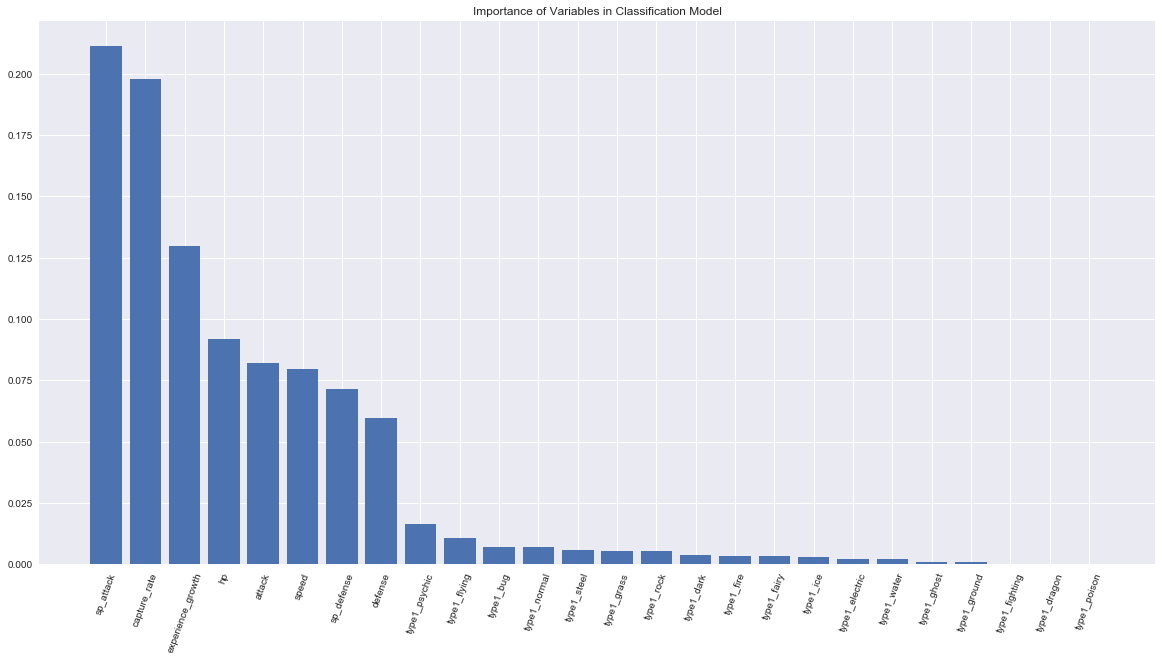

In [70]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, pred_y))

featuresdict = {"feature":X.columns, "importance":list(clf.feature_importances_)}
print(featuresdict)

featuresdf = pd.DataFrame.from_dict(featuresdict)

featuresdf.head()
featuresdf.sort_values("importance", ascending=False, inplace = True)
featuresdf.head()

fig, ax = plt.subplots(figsize = (20,10), )
ax.set_title("Importance of Variables in Classification Model")
ax.bar(np.arange(len(featuresdf)), featuresdf.importance)
ax.set_xticks(np.arange(len(list(features.values()))))
ax.set_xticklabels(featuresdf.feature, rotation = 70);

In [16]:
test.drop(773, inplace = True)
print(test)

     attack capture_rate  defense  experience_growth   hp  sp_attack  \
776      98          180       63            1000000   65         40   
726     115           45       90            1059860   95         80   
339      78           75       73            1000000  110         76   
227      60          120       30            1250000   45         80   
700      92          100       75            1000000   78         74   
251      45           45       35            1059860   40         65   
479      75            3      130            1250000   75         75   
216     130           60       75            1000000   90         75   
546      67           75       85            1000000   60         77   
749     125           60      100            1000000  100         55   
713      30          190       35            1000000   40         45   
704      75           45       53            1250000   68         83   
489     100            3      100            1250000  100       

In [17]:
y_test = test.is_legendary
X_test = test.drop('is_legendary', axis = 1)


X_test.shape

pred_test_y = clf.predict(X_test)

In [18]:
print(np.unique(pred_test_y))
print(accuracy_score(y_test, pred_test_y))

[0 1]
0.975
